<a href="https://colab.research.google.com/github/JD-man/GAN_Study/blob/main/5.ProGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ProGAN

- ProGAN = Progressive GAN
- 풀HD화질로 실제 사진같은 이미지를 생성
- ICLR 2018에 제출된 기법, 즉시 텐서플로 허브에 통합됨  
---
  
### ProGAN의 핵심요소
1. 고해상도 층으로 점진적 증가와 단계적 도입
2. 미니배치 표준편차
3. 균등 학습률
4. 픽셀별 특성 정규화

---
- 이번 챕터에서는 텐서플로 허브를 이용하여 ProGAN을 만든다.
- 실제로는 훈련시간도 길고(1~2달) 워크플로 속도를 높이는 방법을 배워 비지니스에 집중하는 것을 배운다.

# 잠재공간 보간

- 잠재공간 : 출력을 위한 초깃값을 만드는 저해상도 공간
- 얼굴 이미지에 안경을 씌우는 벡터를 찾을 수 있다면 동일한 벡터로 다른 이미지에도 안경을 씌울 수 있다.
- 랜덤한 벡터 두 개를 선택하고 점진적으로 이동하여 부드럽게 변하는 이미지를 얻을 수 있다.

# 고해상도 층으로 점진적 증대와 단계적 도입

### 확률적 경사하강법
- 확률적 경사하강법은 손실함수의 임의위치부터 시작해 손실이 낮은 방향으로 내려온다.
- 만약 복잡한 지역부터 출발한다면 어느 방향으로 이동해야할지 알기 힘들다.  

### 점진적 증대
- 점진적 증대는 특정 지역에 가까워 질때 그 지역만 확대해 복잡도를 늘린다.
- 이 방식은 손실함수에서 밑으로 내려갈때 조금씩 최적화할 수 있는 장점이있다.
- 처음부터 고해상도 층을 사용하면 손실함수가 복잡해 공간을 탐색하기 어렵다.
- 신경망은 저해상도 합성곱 층에서 출발하여 훈련하면서 여러개의 고해상도 층으로 이동한다.
- 몇스텝동안 4X4 크기를 훈련하고 몇번의 에포크를 거쳐 1024X1024 크기를 훈련한다.

### 점진적 증대의 문제점과 대응
- 한번에 하나의 층을 추가할때 (4X4에서 8X8로) 여전히 훈련에 큰 영향을 끼친다.
- ProGAN은 높은 해상도를 바로 도입하지 않고 0~1 사이의 알파 파라미터를 통해 단계적으로 도입한다.
- 알파는 이전층을 업스케일(최근접이웃방식)한 층과 전치 합성곱으로 커진층을 얼마나 사용할지 결정한다.
- 이런식으로 적응이 된 후에 높은 해상도를 남기고 훈련한후에 다시 해상도를 늘린다.

In [ ]:
# 점진적 증대의 구현 예시

import tensorflow as tf
import tensorflow.keras as K

def upscale_layer(layer, upscale_factor):
  '''
  upscale_factor(int)만큼 층(텐서)을 업스케일한다.
  텐서 크기는 [group, height, width, channels]이다.
  '''

  height, width = layer.get_shape()[1:3] # 텐서의 height, width, channels
  size = (upscale_factor * height, upscale_factor * width)
  upscaled_layer = tf.image.resize_nearest_neightbor(layer, size)
  return upscaled_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
  '''
  임계값 알파를 기준으로 층을 부드럽게 합친다.
  이 함수는 모든 층이 이미 RGB로 바뀌었다고 가정함.
  생성자 함수
  list_of_layers : 해상도 순서대로 정렬된 텐서 리스트
  alpha : (0,1) 사이의 실수
  '''

  last_fully_trained_layer = list_of_layers[-2]
  last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)

  larger_native_layer = list_of_layers[-1]

  assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()

  # 곱셈은 브로드캐스팅되어 수행된다.
  new_layer = (1-alpha) * last_layer_upscaled + larger_native_layer * alpha
  return new_layer

# 미니배치 표준편차

- 모드 붕괴는 GAN이 몇 개의 좋은 샘플만 만드는 방법이나 이들의 순서를 조금 바꾸기만할 때 발생한다.
- 따라서 판별자에게 샘플이 충분히 다양한지 알려주는 방법을 만들었다.
- 생성자가 만들거나 실제 데이터에서 온 미니배치에 있는 모든 픽셀의 표준편차를 이용한다.
- 판별자는 평가할 이미지에서 표준편차가 낮다면 이 이미지는 가짜라고 학습한다. 실제 이미지는 분산이 크기 때문이다.
- 생성자는 이에 대응해서 판별자를 속이기 위해 생성 샘플의 분산을 늘린다.
---


In [ ]:
# 미니배치 표준편차 구현예시

def minibatch_std_layer(layer, group_size = 4):
  '''
  층의 미니배치 표준편차를 계산한다.
  층의 데이터 타입은 float32로 가정.
  '''

  group_size = K.backend.minimum(group_size, tf.shape(layer)[0])
  shape = list(K.int_shape(input))
  shape[0] = tf.shape(input)[0]
  
  # 미니배치는 [그룹, 미니배치, 너비, 높이, 채널]이라고 가정한다.
  minibatch = K.backend.reshape(layer, (group_size, -1, shape[1], shape[2], shape[3]))

  # [미니배치M, 너비W, 높이H, 채널C] 그룹의 평균
  minibatch -= tf.reduce_mean(minibatch, axis = 0, keepdims=True)
  # 분산
  minibatch = tf.reduce_men(K.backend.square(minibatch), axis = 0)
  # 표준편차
  minibatch = K.backend.square(minibatch + 1e-8)
  # 특성 맵을 평균하여 [M,1,1,1] 픽셀을 얻는다
  minibatch = tf.reduce_mean(minibatch, axis=[1,2,3], keepdims=True)
  # 스칼라 값을 그룹과 픽셀에 맞게 변환
  minibatch = K.backend.tile(minibatch, [group_size, 1, shape[2], shape[3]])
  # 새로운 특성 맵을 추가한다.
  return K.backend.concatenate([layer, minibatch], axis=1)

# 균등 학습률

- 설명이 뚜렷하지 않은 부분이다.
- 모든 가중치를 어떤 범위 이내러 정규화한다. w' = w / c
- 상수 c는 가중치 행렬의 크기에 따라 결정되므로 층마다 다르다.
- Adam과 비슷하게 가중치 초기화 문제를 해결하는 것으로 보인다.

In [ ]:
# 균등 학습률 구현

def equalize_learning_rate(shape, gain, fan_in=None):
  '''
  He 초기화의 상수로 모든 층의 가중치를 조정하여
  특성마다 각기 다른 다이내믹 레인지를 가지도록 분산을 맞춘다.
  shape : 텐서(층)의 크기 : 각 층의 차원. [커널크기, 커널크기, 필터개수, 특성맵]
  gain : 일반적으로 sqrt(2)
  fan_in : 세이비어/He 초기화에서 입력 연결 개수
  '''

  # 특성 맵 차원을 제외하고 shape의 모든 차원을 곱한다. 뉴런마다 입력 연결 개수를 얻는다.
  if fan_in is None: fan_in = np.prod(shape[:-1])
  # He 초기화 상수
  std = gain / K.sqrt(fan_in)
  # 조정을 위한 상수
  wscale = K.constant(std, name='wscale', dtype=np.float32)
  # 가중치 값을 얻어 브로드캐스팅으로 wscale을 적용
  adjusted_weights = K.get_value('layer', shape=shape, initializer=tf.initializers.random_normal()) * wscale
  return adjusted_weights

# 생성자의 픽셀별 특성 정규화

- 훈련의 안정성을 위해 특성도 정규화해야한다.
- 경험적으로 특성 값이 갑자기 커지는 것이 훈련이 발산되는 초기 신호라는 것을 발견했다.
- 표준 배치 정규화는 높은 해상도를 위해서 너무 많은 메모리가 필요하다.
---
- 픽셀 정규화는 다음 층의 입력으로 들어가기 전에 각 층의 활성화 크기를 사용한다.
1. 위치 (x,y)에서 특성 맵(fm)의 픽셀 값을 얻는다.
2. 각 (x,y)에 대해 다음 같은 벡터를 만든다  
  a. v<sub>0,0</sub> = [fm<sub>1</sub>의 (0,0) 값, fm<sub>2</sub>의 (0,0)값 ...]  
  b. v<sub>0,1</sub> = [fm<sub>1</sub>의 (0,1) 값, fm<sub>2</sub>의 (0,1)값 ...]  
  ...  
  c. v<sub>n,n</sub> = [fm<sub>1</sub>의 (n,n) 값, fm<sub>2</sub>의 (n,n)값 ...]
3. 단위 노름을 가지도록 단계 2에서 정의한 각 벡터 v<sub>i,i</sub>를 정규화한다. 이를 n<sub>i,i</sub>이라 부른다.

  원본 텐서 크기로 다음 층에 전달한다.  
  이 항은 생성자에만 적용된다. 두 네트워크가 경쟁할때 활성화크기가 폭주로 이어지기 때문이다.

In [ ]:
# 픽셀별 특성 정규화 구현예시

def pixelwise_feat_norm(inputs, **kwargs):
  '''
  크리젭스키와 연구진이 2012년 논문에 제안한 픽셀별 특성 정규화
  inputs : 케라스 / TF 층
  '''
  normalization_constant = K.backend.sqrt(K.backend.mean(inputs**2, axis = 1, keepdims=True) + 1.0e-8)
  return inputs / normalization_constant

# 주요 혁신 요약

- ProGAN 논문 저자들은 SWD를 사용한다. 이 값은 작을 수록 좋다.
- SWD는 와서스테인 거리를 최소화하기 위한 실제데이터와 생성 샘플의 조각을 의미한다.
- 책에 나와있는 효과에대한 표는 미니배치가 잘 동작하지 않는다는 것을 보여준다.
- 메가픽셀크기를 소화할 GPU의 램이 부족하기 때문. 미니배치의 크기를 줄이면 효과는 더 내려간다.
- 균등학습률과 픽셀별 정규화는 훈련효과를 조금 더 향상시킨다.

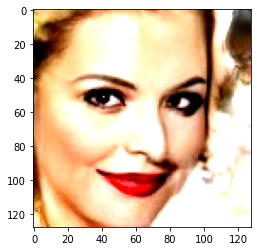

In [ ]:
# 텐서플로 허브를 사용한 실습

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# TFHub에서 ProGAN을 임포트한다. 임포트는 URL주소로 하며 접속하면 모듈에대한 설명이 나온다.
module = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')
# 생성샘플의 잠재공간차원
latent_dim = 512

# 잠재 벡터. 시드를 변경하면 다른 이미지가 나온다
latent_vector = tf.random.normal([1, latent_dim], seed=1337)

# 모듈을 사용해 잠재 벡터를 이용해 이미지를 생성
interpolated_images = module(latent_vector)
# 텐서플로 허브의 ProGAN 버전은 1024X1024가 아닌 128X128을 사용한다. 풀버전을 사용하려면 많은 컴퓨팅 자원이 필요하기 때문.
plt.imshow(interpolated_images.numpy().reshape(128,128,3))
plt.show()

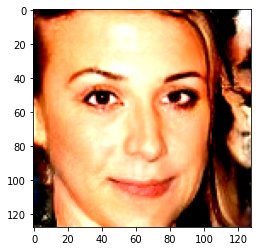

In [ ]:
latent_vector = tf.random.normal([1, latent_dim], seed=3)
interpolated_images = module(latent_vector)
# 텐서플로 허브의 ProGAN 버전은 1024X1024가 아닌 128X128을 사용한다. 풀버전을 사용하려면 많은 컴퓨팅 자원이 필요하기 때문.
plt.imshow(interpolated_images.numpy().reshape(128,128,3))
plt.show()